In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from IceNet import dataloader
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

### Load pulses

In [4]:
from IceNet.dataloader import get_pulses

In [5]:
labels = [
    'azimuth',
    'zenith',
]

In [9]:
fnames = ['oscNext_genie_level3_v01.03_pass2.140000.0000%02i' % (i) for i in range(1,3)]

In [10]:
def _read_files(file_list, labels):
    x, y = [], []
    for files in file_list:
        print(files)
        xx, yy = get_pulses('./input/'+files+'.hdf5', labels=labels)
        x.append(xx)
        y.append(yy)
    flatten = lambda superlist: [x for sublist in superlist for x in sublist]
    x = flatten(x)
    y = flatten(y)
    return x, y 

In [11]:
x, y = _read_files(fnames, labels)

oscNext_genie_level3_v01.03_pass2.140000.000001



oscNext_genie_level3_v01.03_pass2.140000.000002


In [12]:
# Convert to cartesian if necessary
import math
def polar2cart(r, phi, theta):
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

### Filter energy

### Filter events with many pulses

In [13]:
max_pulses = 50
pulse_mask = [i for i, event in enumerate(x) if len(event) < max_pulses]

In [14]:
x_filtered = [x[i] for i in pulse_mask]
# y_filtered = [np.array([y[i]]) for i in pulse_mask]
# y_transformed = [np.array([np.sin(y[i]), np.cos(y[i])]).reshape(1,-1) for i in pulse_mask] # In case of zenith angle
y_transformed = [polar2cart(1, *y[i]) for i in pulse_mask] 
# y_filtered = [np.log10(y[i])for i in pulse_mask] # In case of energy

### Convert time to position

In [17]:
col_t = 1
c = 299792458 # mps

In [18]:
xt = np.copy(x_filtered)
time_to_pos = [event[:,col_t]*1e-9*c for event in xt]
time_to_pos = [time.reshape(-1, 1) for time in time_to_pos]

### Use DOM positional information

In [19]:
from IceNet.icecubeutils import get_dom_positions
dom_positions = get_dom_positions()

In [20]:
hit_doms = [dom_positions[event[:,0].astype(int)] for event in x_filtered]

### Join all positional information

In [21]:
all_pos = [np.concatenate((time, pos), axis=1) for time, pos in zip(time_to_pos, hit_doms)]

### Calculate distance matrices

In [22]:
def calc_dist_matrix(event):
    npulses = len(event)
    idx = np.asarray(list(np.ndindex((npulses, npulses))))
    calc_dist = lambda i, j: np.linalg.norm(event[i] - event[j]) \
                            * np.sign(event[j, 0] - event[i, 0])
    
    dist_matrix = np.vectorize(calc_dist)(idx[:,0], idx[:,1])
    dist_matrix = dist_matrix.reshape((npulses, npulses))
    return dist_matrix

In [23]:
# dists = [calc_dist_matrix(event) for event in tqdm(all_pos)]

In [24]:
import pickle


dists = np.concatenate([pickle.load(open('./processed_files/'+str(fname)+'_max_pulses_'+str(max_pulses)+'_dists.p', 'rb'))
                        for fname in fnames])

In [25]:
if len(dists) != len(all_pos):
    print(len(dists), len(all_pos))
    raise ValueError()

### Convert distances to weights
Try Gaussian kernel for starters

In [26]:
from scipy.stats import norm

In [27]:
# from scipy.stats import norm

# gauss = norm(scale=100)

# weights = [gauss.pdf(m) / gauss.pdf(0) * np.sign(m) for m in tqdm(dists)] 

In [28]:
### 1/d2 weights
qq=1e-3
weights = [1/(1+qq*m**2)*np.sign(m) for m in tqdm(dists)]

### Prepare feature input
log(charges), xyz, then normalize

In [30]:
features = [np.concatenate((np.log10(event[:,2].reshape(-1,1)), # log charges
                            doms, # xyz
                            event[:,1].reshape(-1,1) # Time
                           ), axis=1) 
            for event, doms in zip(x_filtered, hit_doms)]

### Normalize

In [31]:
from IceNet.datautils.pulsenormalizer import PulseNormalizer

In [32]:
pn = PulseNormalizer(features)

In [33]:
features_normalized = pn.normalize(mode='gauss')

In [34]:
def shift_features(feature_list, col, mode, weight_col=None):
    new_list = []
    for event in tqdm(feature_list):
        new_event = np.copy(event)
        shift_features = new_event[:, col]
        if mode=='median':
            m = np.median(shift_features, axis=0)
        elif mode=='mean':
            m = np.mean(shift_features, axis=0)
        elif mode=='weighted':
            m = np.average(shift_features, axis=0, weights=new_event[:, weight_col])
        else:
            raise ValueError('No mode specified')
        shift_features -= m
        new_event[:, col] = shift_features
        new_list.append(new_event)
    return new_list
            

In [36]:
features_shifted = shift_features(features_normalized, 1, 'mean')

### Prepare edge information

In [37]:
def get_edge_info(weight_matrix):
    n_pulses = weight_matrix.shape[0]
    idx = np.asarray(list(np.ndindex((n_pulses, n_pulses))))
    edge_weights = np.asarray([weight_matrix[i,j] for i,j in idx])
    idx = np.swapaxes(idx, 0, 1)
    return idx, edge_weights

In [38]:
edges, edge_weights = get_edge_info(weights[0])

In [39]:
import torch
from torch_geometric.data import Data

### Normalize labels

In [41]:
labels_normalized = np.copy(y_filtered)
labels_normalized = (labels_normalized - np.mean(y_filtered)) / (np.std(y_filtered))

NameError: name 'y_filtered' is not defined

In [43]:
pn_labels = PulseNormalizer(y_transformed)

AttributeError: 'list' object has no attribute 'shape'

In [44]:
labels_normalized = pn_labels.normalize('gauss')

NameError: name 'pn_labels' is not defined

In [45]:
labels_normalized = np.squeeze(y_transformed)

<IPython.core.display.Javascript object>


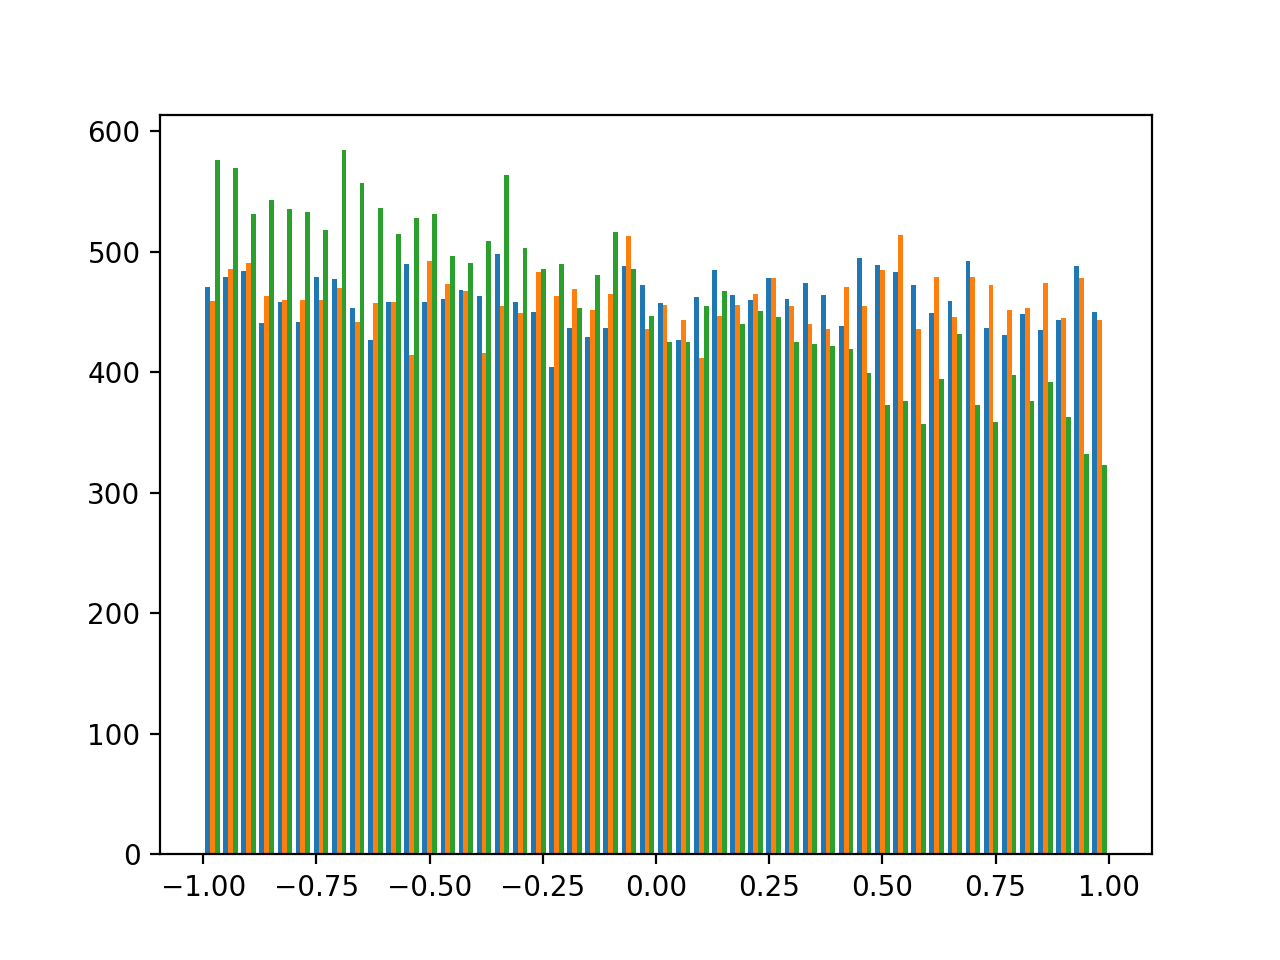

In [46]:
plt.figure()
plt.hist(np.asarray(labels_normalized), bins=50)
plt.show()

### Prepare datasets

In [47]:
data_list = []
for features, w, truth in tqdm(zip(features_normalized, weights, labels_normalized), total=len(labels_normalized)):
    edge_index, edge_weights = get_edge_info(w)
    dd = Data(x=torch.tensor(features, dtype=torch.float),
              y=torch.tensor(truth, dtype=torch.float),
              edge_index=torch.tensor(edge_index, dtype=torch.long),
              edge_attr=torch.tensor(edge_weights, dtype=torch.float),
             )
    data_list.append(dd)
    

In [48]:
data_list[0]

Data(edge_attr=[25], edge_index=[2, 25], x=[5, 5], y=[3])

In [49]:
randperm = np.random.permutation(len(data_list))
dataset_modified = [data_list[i] for i in randperm]

In [50]:
def get_k_fold_sets(dataset, k, i, n_samples=None):
    n_samples = n_samples if n_samples else len(dataset)
    n_samples = n_samples - n_samples%k
    dataset = dataset[:n_samples]
    n_subset = n_samples // k
    val_mask = np.arange(i*n_subset, (i+1)*n_subset)
    val_set = [data for i, data in enumerate(dataset) if i in val_mask]
    test_set = [data for i, data in enumerate(dataset) if i not in val_mask]
    return test_set, val_set

### Prepare Neural Net

In [51]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn import BatchNorm1d, PReLU
import torch_geometric.nn as NN
from torch_geometric.utils import to_dense_adj, to_dense_batch

In [52]:
class LLHFreeConvNet(torch.nn.Module):
    """
    Base class for a GCN.
    """
    def __init__(self):
        super(LLHFreeConvNet, self).__init__()
        
#         # Reco
        n_intermediate = 64
        n_intermediate2 = 128
        self.n_features = 5
        
        self.conv1 = NN.GraphConv(self.n_features, n_intermediate)
#         self.conv_hidden1 = NN.GCNConv(n_intermediate, n_intermediate)
        self.conv2 = NN.GraphConv(n_intermediate, n_intermediate2)
        self.batchnorm1 = BatchNorm1d(n_intermediate2)
        self.linear1 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear2 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear3 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear4 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear5 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.drop = torch.nn.Dropout(.3)
        
#         self.linear_out = torch.nn.Linear(n_intermediate2, 1)
        
#         self.out = torch.nn.Linear(n_intermediate2, self.n_labels)

#         self.conv_net = ConvNet()
#         self.conv_net.load_state_dict(torch.load('./ConvNet_z_20k_modified.torch'))
        
        # Params
        self.n_params = 3
        n_hidden_params_1 = 128
        self.fc_params1 = torch.nn.Linear(self.n_params, n_hidden_params_1)
        self.fc_params2 = torch.nn.Linear(n_hidden_params_1, n_hidden_params_1)
        self.fc_params3 = torch.nn.Linear(n_hidden_params_1, n_hidden_params_1)
        self.fc_params4 = torch.nn.Linear(n_hidden_params_1, n_hidden_params_1)
        self.fc_params5 = torch.nn.Linear(n_hidden_params_1, n_hidden_params_1)
        self.drop_params = torch.nn.Dropout()
        
#         self.fc_params_out = torch.nn.Linear(n_hidden_params_1, 64)
        
        # Combined
        n_combined = 128
        self.fc_combined1 = torch.nn.Linear(n_intermediate2+n_hidden_params_1, n_combined)
        self.fc_combined2 = torch.nn.Linear(n_combined, n_combined)
        self.fc_combined3 = torch.nn.Linear(n_combined, n_combined)
        self.fc_combined4 = torch.nn.Linear(n_combined, n_combined)
        self.fc_combined5 = torch.nn.Linear(n_combined, n_combined)
        self.drop_combined = torch.nn.Dropout()
        
        self.out = torch.nn.Linear(n_combined, 1)
        
        
    def forward(self, data, hidden=None):
        x = data.x
        edge_index = data.edge_index
        edge_weights = data.edge_attr
        batch = data.batch
        y = data.y if hidden==None else hidden
        y = y.view(batch_size, -1)
        
        # Reco
        x = self.conv1(x, edge_index, edge_weights)
        
#         x = self.conv_hidden1(x, edge_index, edge_weights,)
        
        x = self.conv2(x, edge_index, edge_weights,)
        x = global_add_pool(x, batch)
    
#         x = self.batchnorm1(x)
        
        x = F.leaky_relu(self.linear1(x))
        x = self.drop(x)
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
#         x = F.leaky_relu(self.linear4(x))
#         x = F.leaky_relu(self.linear5(x))
        
#         x = F.leaky_relu(self.linear_out(x))
        
        
#         x = self.out(x)
#         x = x.view(-1)
#         return x

#         x = self.conv_net(data)
        
        # Params
        
        y = F.leaky_relu(self.fc_params1(y))
        y = self.drop_params(y)
        y = F.leaky_relu(self.fc_params2(y))
        y = F.leaky_relu(self.fc_params3(y))
        y = F.leaky_relu(self.fc_params4(y))
        y = F.leaky_relu(self.fc_params5(y))
        
#         y = F.relu(self.fc_params_out(y))
        
        z = torch.cat((x, y), dim=1)
        
        
        z = F.relu(self.fc_combined1(z))
        z = self.drop_combined(z)
        z = F.relu(self.fc_combined2(z))
        z = F.relu(self.fc_combined3(z))
        z = F.relu(self.fc_combined4(z))
        z = F.relu(self.fc_combined5(z))
        
        z = torch.sigmoid(self.out(z))
#         x = x.view(-1, self.n_labels)
#         x = x.squeeze()
#         x = x.view(-1,1)
        z = z.view(-1)

        return z

In [53]:
len(dataset_modified)

23023

In [54]:
# dataset_modified =data_list
n_train = 5000
n_val = 1024
n_test = 000
if n_train + n_val + n_test > len(dataset_modified):
    print(len(dataset_modified))
    raise IndexError('Set sizes exceed data sample')
train_set = dataset_modified[:n_train]
val_set = dataset_modified[n_train:n_train+n_val]
test_set = dataset_modified[-n_test:]


from torch_geometric.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_set, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, drop_last=True)

In [55]:
train_set[0].y

tensor([ 0.2058, -0.9159, -0.3445])

In [56]:
def get_random_permutation_loader(sample_set):
    random_perm = np.random.permutation(len(sample_set))
    random_set = [sample_set[i] for i in random_perm]
    random_loader = DataLoader(random_set, batch_size=batch_size, drop_last=True)
    return random_loader
    

In [63]:
import matplotlib.pyplot as plt
%matplotlib notebook

# device = torch.device('cpu')
device = torch.device('cuda')
model = LLHFreeConvNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                            weight_decay=1e-5,
                            )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=.5)
crit = torch.nn.BCELoss()

In [64]:
def step(batch, label, train=False):
    data = data.to(device)
    if train:
        optimizer.zero_grad()
    output = model(batch)
    label = truth.to(device)
    loss = crit(output, label)
    loss_all += float(data.num_graphs * (loss.item()))
    if train:
        loss.backward()
        optimizer.step()

<IPython.core.display.Javascript object>


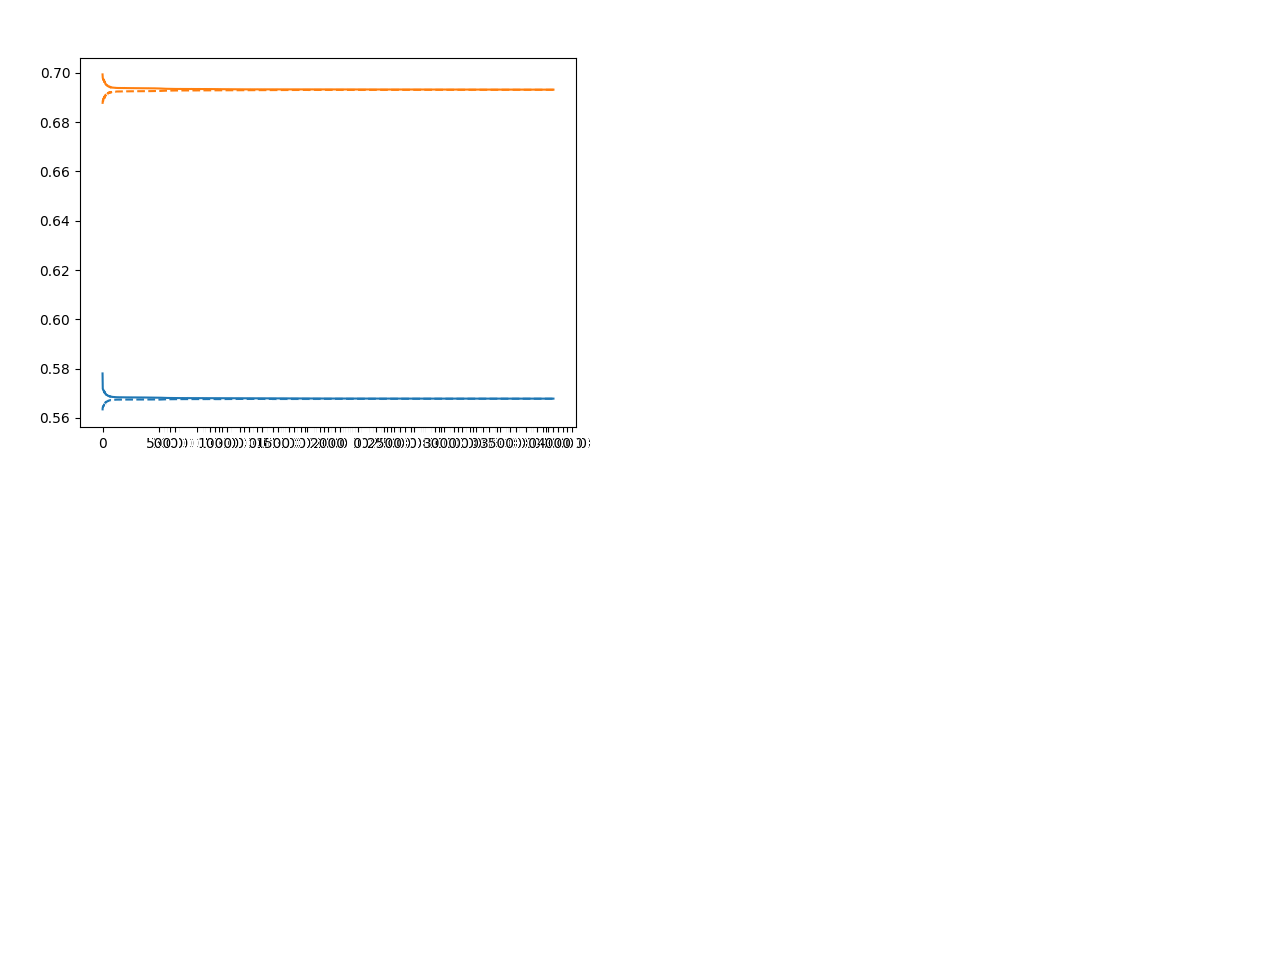

Iter 0, Learning rate 0.001000
Iter 500, Learning rate 0.000250
Iter 501, Learning rate 0.000500
Iter 1000, Learning rate 0.000125
Iter 1001, Learning rate 0.000250
Iter 1500, Learning rate 0.000063
Iter 1501, Learning rate 0.000125
Iter 2000, Learning rate 0.000031
Iter 2001, Learning rate 0.000063
Iter 2500, Learning rate 0.000016
Iter 2501, Learning rate 0.000031
Iter 3000, Learning rate 0.000008
Iter 3001, Learning rate 0.000016
Iter 3500, Learning rate 0.000004
Iter 3501, Learning rate 0.000008
Iter 4000, Learning rate 0.000002
Iter 4001, Learning rate 0.000004


KeyboardInterrupt: 

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

last_lr = float('inf')

truth = torch.tensor(np.ones(batch_size), dtype=torch.float)
untruth = torch.tensor(np.zeros(batch_size), dtype=torch.float)

train_losses = []
train_untruth_losses = []
val_losses = []
val_untruth_losses = []
model_pars = []

epoch_bar = tqdm(range(5000))
model.train()

for epoch in epoch_bar:
    # Train
    loss_all = 0
    loss_untruth = 0
    random_perm = np.random.permutation(len(train_set))
    random_set = [train_set[i] for i in random_perm]
    random_loader = DataLoader(random_set, batch_size=batch_size, drop_last=True)
    for data, random_pick in zip(train_loader, random_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = truth.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += float(data.num_graphs * (loss.item()))
        optimizer.step()
        
        optimizer.zero_grad()
        label = untruth.to(device)
        output = model(data, random_pick.y.to(device))
        loss = crit(output, label)
        loss.backward()
#         loss_all += float(data.num_graphs * (loss.item()))
        loss_untruth += float(data.num_graphs * (loss.item()))
        
        optimizer.step()

    train_losses.append(loss_all / len(train_loader.dataset))
    train_untruth_losses.append(loss_untruth / len(train_loader.dataset))
#     model_pars.append(model.state_dict())

    # Validate
    random_loader = get_random_permutation_loader(val_set)
    with torch.no_grad():
        val_loss_all = 0 
        val_loss_untruth = 0 
        for val_batch, random_pick in zip(val_loader, random_loader):
            val_data = val_batch.to(device)
            val_label = truth.to(device)
            out_val = model(val_data)
            val_loss = crit(out_val, val_label)
            val_loss_all += float(val_data.num_graphs * (val_loss.item()))
            
            label = untruth.to(device)
            output = model(data, random_pick.y.to(device))
            loss = crit(output, label)
            val_loss_untruth += float(val_data.num_graphs * (loss.item()))
#             val_loss_all += float(val_data.num_graphs * (val_loss.item()))
            
    val_losses.append(val_loss_all / len(val_loader.dataset))
    val_untruth_losses.append(val_loss_untruth / len(val_loader.dataset))
    epoch_bar.set_description("Train: %.2e, val: %.2e" % (train_losses[-1], val_losses[-1]))

    if val_loss_all / len(val_loader.dataset) <= min(val_losses):
        best_model = model


#     plt.scatter(epoch, loss_all)
    ax.clear()
#     ax.plot(np.arange(epoch+1), train_losses)
    plt.plot(train_losses, label="Training", c='C0')
    plt.plot(train_untruth_losses, label="Training", c='C0', ls='--')
    plt.plot(val_losses, label="Validation", c='C1')
    plt.plot(val_untruth_losses, label="Validation", c='C1', ls='--')
#     plt.yscale('log')
    fig.canvas.draw()
    plt.pause(0.05)


    if scheduler.get_lr()[0] != last_lr:
        last_lr = scheduler.get_lr()[0]
        print('Iter %i, Learning rate %f' % (epoch, last_lr))

    scheduler.step()
    
plt.show()

In [197]:
np.min(val_losses), np.argmin(val_losses)

(0.6131622791290283, 227)

In [ ]:
np.min(train_losses[:1000]), np.argmin(train_losses[:1000])

In [198]:
def torch_to_numpy(x):
    return np.asarray(x.cpu().detach())

In [199]:
def get_grid_loader(sample, lin, batch_size):
    grids = np.meshgrid(*([lin]*model.n_params))
    input_grids = np.array([grid.flatten() for grid in grids])
    input_grids = np.swapaxes(input_grids, 0, 1)
    grid_set = [Data(x=sample.x,
                     edge_index=sample.edge_index,
                     edge_attr=sample.edge_attr,
                     y=torch.tensor(grid_sample, dtype=torch.float)) for grid_sample in input_grids]
    grid_loader = DataLoader(grid_set, batch_size=batch_size)
    return grid_loader, input_grids

In [200]:
import copy
# class EvaluatorBase:
#     def __init__(self, test_sample, n_points, batch_size):
#         self.test_sample = test_sample
#         self._batch_size = batch_size
#         self.grid_loader = self._get_loader()
        
#     def _get_loader(self):
#         grid_set = []
#         for coord in self.input_grid_trainsformed:
#             grid_input = copy.deepcopy(self.test_sample)
#             grid_input.y = torch.tensor(coord, dtype=torch.float)
#             grid_set.append(grid_input)

#         grid_loader = DataLoader(grid_set, batch_size=self._batch_size)
#         return grid_loader

class EvaluatorZenith:
    def __init__(self, test_sample, n_points, batch_size):
        self.test_sample = test_sample
        self._batch_size = batch_size
        self.line_zenith = np.linspace(0, np.pi, n_points)
#         self.sin_zenith = np.sin(self.line_zenith)
#         self.cos_zenith = np.cos(self.line_zenith)
#         self.mesh = np.meshgrid(self.sin_zenith, self.cos_zenith)
#         self.input_grid = np.array([m.flatten() for m in az_mesh]).T
        self.input_grid_transformed = np.array([np.sin(self.line_zenith), np.cos(self.line_zenith)]).T
        self.grid_loader = self._get_loader()
        
    def _get_loader(self):
        grid_set = []
        for coord in self.input_grid_transformed:
            grid_input = copy.deepcopy(self.test_sample)
            grid_input.y = torch.tensor(coord, dtype=torch.float)
            grid_set.append(grid_input)

        grid_loader = DataLoader(grid_set, batch_size=self._batch_size)
        return grid_loader



class EvaluatorPolar:
    def __init__(self, test_sample, n_points, batch_size):
        self.test_sample = test_sample
        self._batch_size = batch_size
        self.line_azimuth = np.linspace(0, 2*np.pi, n_points)
        self.line_zenith = np.linspace(0, np.pi, n_points)
        self.az_mesh = np.meshgrid(self.line_azimuth, self.line_zenith)
        self.input_grid = np.array([m.flatten() for m in self.az_mesh]).T
        self.input_grid_transformed = [polar2cart(1, *az) for az in self.input_grid]
        self.grid_loader = self._get_loader()
        
    def _get_loader(self):
        grid_set = []
        for coord in self.input_grid_transformed:
            grid_input = copy.deepcopy(self.test_sample)
            grid_input.y = torch.tensor(coord, dtype=torch.float)
            grid_set.append(grid_input)

        grid_loader = DataLoader(grid_set, batch_size=self._batch_size)
        return grid_loader


In [201]:
def cart2polar(x, y, z):
    phi = np.arctan2(y,z)
    phi += 2*np.pi if phi < 0 else 0
    return [phi,
           np.arctan2(np.sqrt(x**2 + y**2) , z)]

In [202]:
test_set = train_set


n_points = 32

if n_points < (batch_size**int(1/model.n_params)):
    raise ValueError

n_points = n_points - (n_points%batch_size**int(1/model.n_params))

    
lin = np.linspace(-5,5, n_points)
test_idx = np.random.randint(len(test_set))
test_sample = test_set[test_idx]
# grid_loader, input_grids = get_grid_loader(test_sample, lin, batch_size)
# grid_loader, input_grids = get_grid_loader_az(test_sample, n_points, batch_size)
evaluator = EvaluatorPolar(test_sample, n_points, batch_size)
grid_loader = evaluator.grid_loader


with torch.no_grad():
    model_cpu = model.cpu()
    model_cpu.eval()
    pred = torch.cat([model(batch) for batch in tqdm(grid_loader)])

80635


/home/iwsatlas1/haminh/IceCube/deepLearning/tf1/lib/python3.7/site-packages/scipy-1.1.0-py3.7-linux-x86_64.egg/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=32,37 m=1024 fp=0.000155 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


<IPython.core.display.Javascript object>


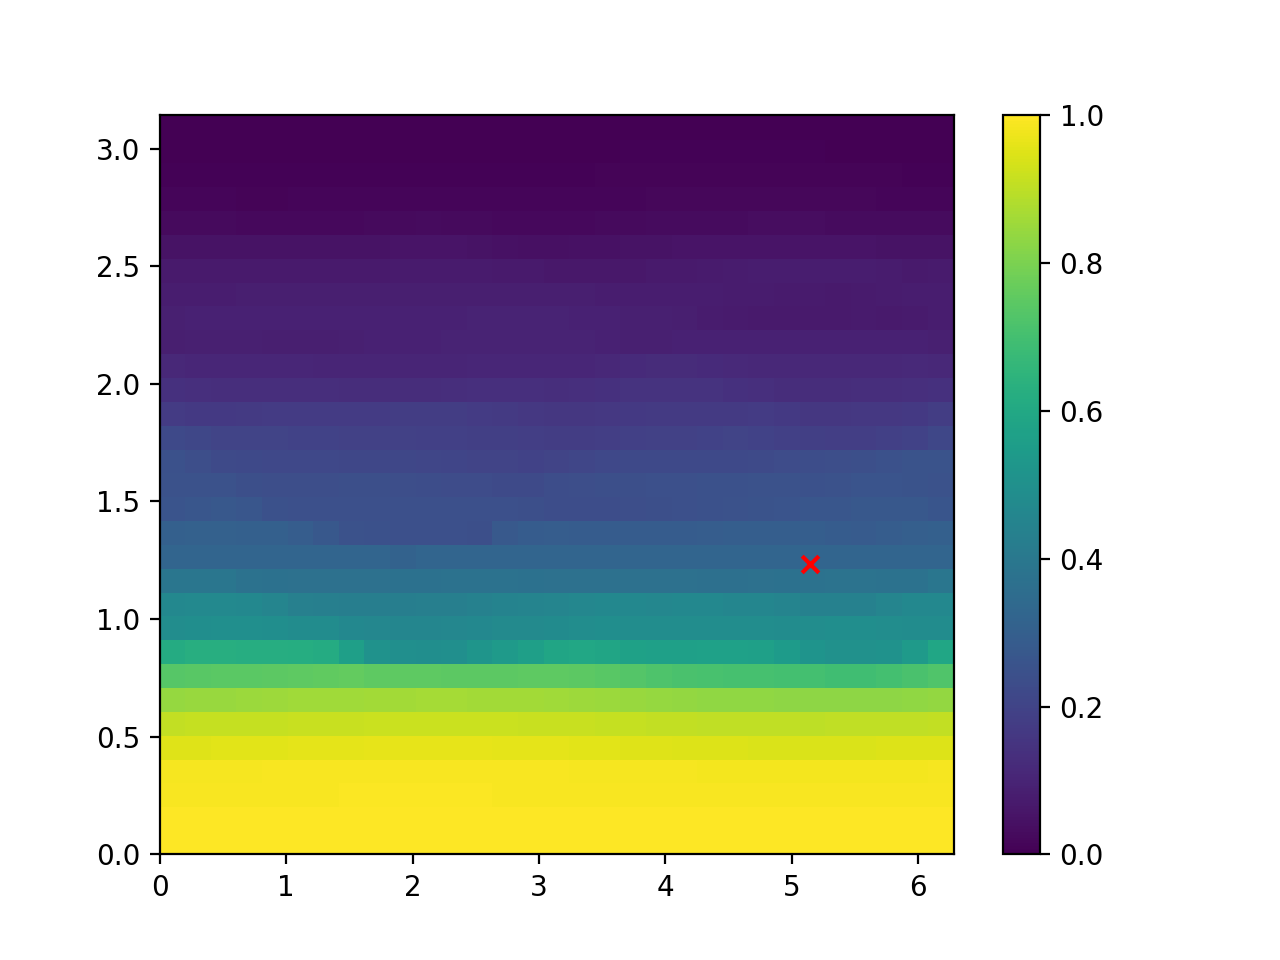

In [203]:
from scipy.interpolate import interp2d

prob = torch_to_numpy(pred)
prob = prob/(1-prob)
inter = interp2d(evaluator.input_grid[:,0], evaluator.input_grid[:,1], prob)
# inter = interp2d(evaluator.input_grid_transformed[:,0], evaluator.input_grid_transformed[:,1], prob)


print(test_idx)
plt.figure()

# meshy = np.meshgrid(*([lin]*model.n_params))
# meshy = np.meshgrid(*([lin]*model.n_params))
# plt.plot(evaluator.line_zenith, prob)
# plt.axvline(np.arctan2(*test_sample.y))
plt.pcolormesh(*evaluator.az_mesh, inter(evaluator.line_azimuth, evaluator.line_zenith))
# plt.pcolormesh(*meshy, prob.reshape(n_points, n_points))
# plt.pcolormesh(*meshy, inter(lin, lin))
plt.scatter(*cart2polar(*(torch_to_numpy(test_sample.y))), c='r', marker='x')
plt.colorbar()
plt.show()

In [204]:
evaluator.input_grid

array([[0.        , 0.        ],
       [0.2026834 , 0.        ],
       [0.40536679, 0.        ],
       ...,
       [5.87781851, 3.14159265],
       [6.08050191, 3.14159265],
       [6.28318531, 3.14159265]])

In [205]:
elements = []
for xx, yy in input_grids:
    angle = np.arctan2(xx,yy)
    elements.append(angle)

NameError: name 'input_grids' is not defined

In [ ]:
import copy

In [ ]:
plt.figure()
plt.plot(np.asarray(pred).T[1])
plt.show()

In [ ]:
plt.figure()
# plt.scatter(elements, prob)
plt.hist(elements, weights=prob, bins=50)
plt.axvline(np.arctan2(*test_sample.y[0]), c='r')
plt.show()

In [ ]:
from IceNet.dataloader import get_data_3d
_,y_reco,reco = get_data_3d('./input/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', min_pulses=1, 
                            labels=['zenith'],
                            reco_labels=['zenith'],
                           )

In [ ]:
nan_mask = np.where(~np.isnan(reco))

In [ ]:
reco = reco[nan_mask]
y_reco = y_reco[nan_mask]

In [ ]:
train_reco = recoset[:, :n_train]
val_reco = recoset[:, n_train:n_train+n_val]
test_reco = recoset[:, -n_test:]

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
def get_bands(hist):
    sigma = .6827
    binc, xedges, yedges, _ = hist
    xbins = (xedges[1:] + xedges[:-1]) / 2
    ybins = (yedges[1:] + yedges[:-1]) / 2
    
    lower_band = []
    upper_band = []
    for sliice, x in zip(binc, xbins):
        cumulative = np.cumsum(sliice)
        total = np.sum(sliice)
        imax = np.argmin(np.abs(cumulative - total*(1+sigma)/2))
        imin = np.argmin(np.abs(cumulative - total*(1-sigma)/2))
        lower_band.append(ybins[imin])
        upper_band.append(ybins[imax])
    
    return xbins, lower_band, upper_band

<IPython.core.display.Javascript object>


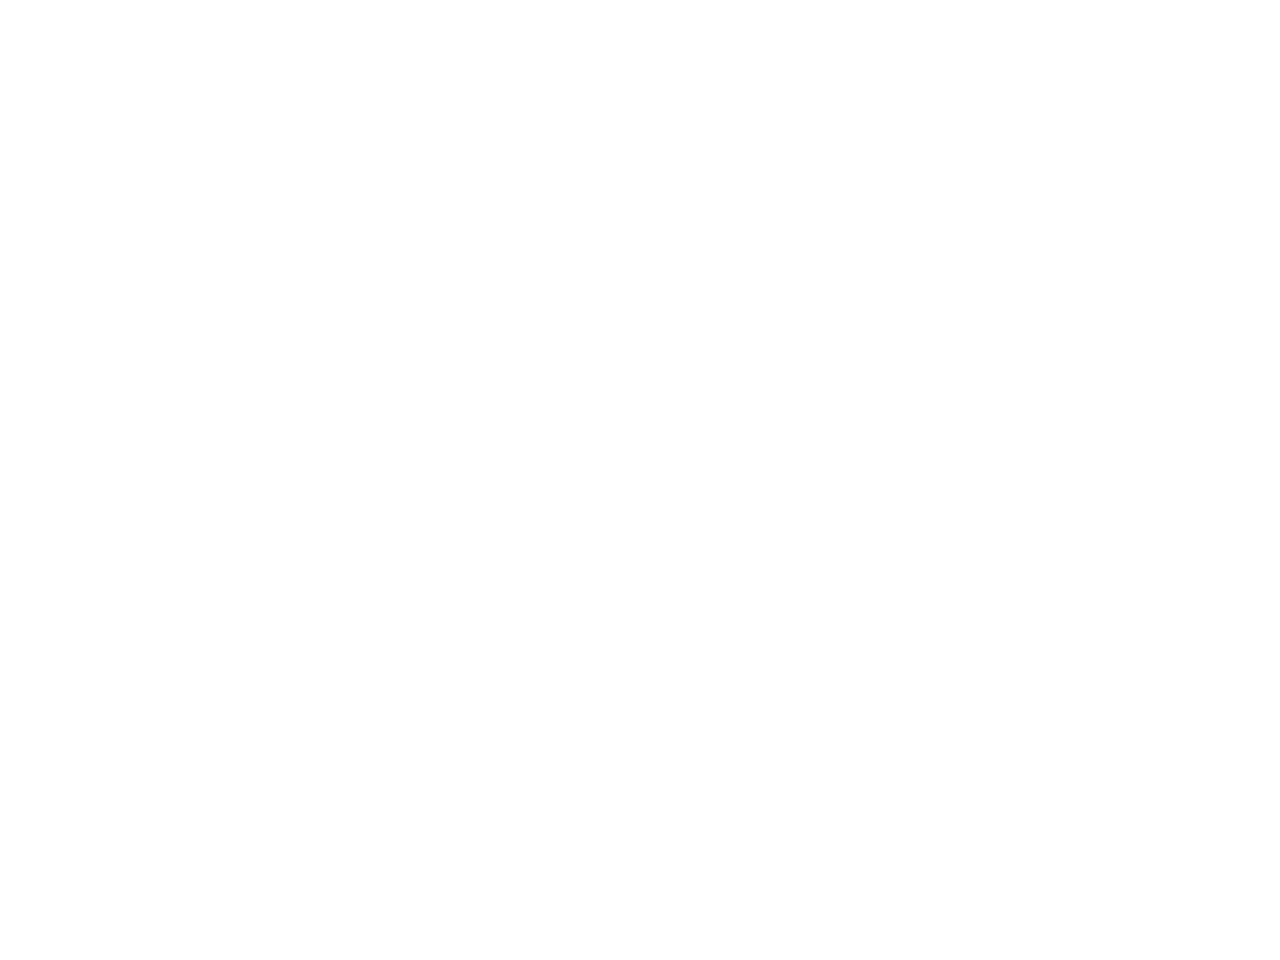

tensor([[0.8723],
        [0.9944]], device='cuda:0')
tensor([[-0.9076],
        [ 0.5514]], device='cuda:0')
tensor([[ 0.6158],
        [-0.3637]], device='cuda:0')
tensor([[-1.1351],
        [ 0.1979]], device='cuda:0')
tensor([[1.3482],
        [0.5438]], device='cuda:0')
tensor([[0.2693],
        [0.0778]], device='cuda:0')
tensor([[ 0.0617],
        [-0.6855]], device='cuda:0')
tensor([[-0.9985],
        [-0.0534]], device='cuda:0')
tensor([[0.8774],
        [1.0685]], device='cuda:0')
tensor([[1.6444],
        [1.3136]], device='cuda:0')
tensor([[1.1489],
        [1.1613]], device='cuda:0')
tensor([[-0.7679],
        [-0.9592]], device='cuda:0')
tensor([[ 1.2654],
        [-0.7271]], device='cuda:0')
tensor([[0.8689],
        [1.4754]], device='cuda:0')
tensor([[1.1785],
        [1.4010]], device='cuda:0')
tensor([[0.1510],
        [1.0592]], device='cuda:0')
tensor([[1.4047],
        [0.9799]], device='cuda:0')
tensor([[-1.1239],
        [-0.4691]], device='cuda:0')
tensor([[1.1

tensor([[1.1474],
        [1.1235]], device='cuda:0')
tensor([[ 0.4854],
        [-0.9411]], device='cuda:0')
tensor([[-0.0368],
        [ 0.0293]], device='cuda:0')
tensor([[-1.3900],
        [ 1.5041]], device='cuda:0')
tensor([[ 1.4605],
        [-0.8482]], device='cuda:0')
tensor([[ 0.1481],
        [-0.9058]], device='cuda:0')
tensor([[-1.3452],
        [-0.1712]], device='cuda:0')
tensor([[-0.2267],
        [-1.9258]], device='cuda:0')
tensor([[-0.8758],
        [-0.3020]], device='cuda:0')
tensor([[1.2203],
        [1.8291]], device='cuda:0')
tensor([[-0.4126],
        [-1.0062]], device='cuda:0')
tensor([[ 0.8867],
        [-1.5927]], device='cuda:0')
tensor([[-0.2088],
        [-1.5203]], device='cuda:0')
tensor([[1.3176],
        [0.7864]], device='cuda:0')
tensor([[-0.3562],
        [ 0.2470]], device='cuda:0')
tensor([[ 0.4231],
        [-0.8726]], device='cuda:0')
tensor([[-0.9573],
        [ 0.3540]], device='cuda:0')
tensor([[-0.1963],
        [ 0.4485]], device='cuda:0'

tensor([[ 0.0424],
        [-0.2581]], device='cuda:0')
tensor([[-0.0207],
        [ 1.5248]], device='cuda:0')
tensor([[ 1.1701],
        [-0.5566]], device='cuda:0')
tensor([[0.1914],
        [0.6958]], device='cuda:0')
tensor([[-0.1692],
        [ 1.2814]], device='cuda:0')
tensor([[1.0174],
        [0.8187]], device='cuda:0')
tensor([[ 0.5961],
        [-0.3505]], device='cuda:0')
tensor([[ 0.3978],
        [-0.0722]], device='cuda:0')
tensor([[0.3688],
        [0.9448]], device='cuda:0')
tensor([[-0.8053],
        [-0.1204]], device='cuda:0')
tensor([[-1.3201],
        [ 0.7564]], device='cuda:0')
tensor([[ 0.9838],
        [-0.0106]], device='cuda:0')
tensor([[-1.3504],
        [ 1.4674]], device='cuda:0')
tensor([[ 1.0160],
        [-0.2169]], device='cuda:0')
tensor([[-1.1976],
        [-0.5327]], device='cuda:0')
tensor([[ 1.3689],
        [-0.5449]], device='cuda:0')
tensor([[-0.4735],
        [ 0.8534]], device='cuda:0')
tensor([[ 0.8502],
        [-0.9052]], device='cuda:0'

tensor([[0.2418],
        [0.2901]], device='cuda:0')
tensor([[ 0.3433],
        [-0.4973]], device='cuda:0')
tensor([[-0.6221],
        [ 1.6783]], device='cuda:0')
tensor([[ 1.0755],
        [-0.0097]], device='cuda:0')
tensor([[-1.1308],
        [ 1.2077]], device='cuda:0')
tensor([[ 0.3265],
        [-1.0253]], device='cuda:0')
tensor([[0.7939],
        [0.8880]], device='cuda:0')
tensor([[-1.1637],
        [-0.9760]], device='cuda:0')
tensor([[-0.7122],
        [ 2.1006]], device='cuda:0')
tensor([[0.7217],
        [1.0184]], device='cuda:0')
tensor([[-0.4765],
        [ 0.9818]], device='cuda:0')
tensor([[-0.5058],
        [-1.2035]], device='cuda:0')
tensor([[0.8839],
        [0.2437]], device='cuda:0')
tensor([[-0.1802],
        [-0.3742]], device='cuda:0')
tensor([[-1.1494],
        [ 0.3975]], device='cuda:0')
tensor([[-0.2616],
        [ 1.7130]], device='cuda:0')
tensor([[1.3385],
        [0.8794]], device='cuda:0')
tensor([[0.8282],
        [0.4670]], device='cuda:0')
tens

tensor([[ 0.0155],
        [-0.4810]], device='cuda:0')
tensor([[ 1.2195],
        [-0.2685]], device='cuda:0')
tensor([[ 0.9328],
        [-0.8981]], device='cuda:0')
tensor([[0.3257],
        [0.6001]], device='cuda:0')
tensor([[-0.3724],
        [-1.0923]], device='cuda:0')
tensor([[-2.0457],
        [ 0.9797]], device='cuda:0')
tensor([[ 1.2807],
        [-0.8505]], device='cuda:0')
tensor([[0.1402],
        [0.4298]], device='cuda:0')
tensor([[-0.8905],
        [-0.3507]], device='cuda:0')
tensor([[ 1.1387],
        [-1.7639]], device='cuda:0')
tensor([[-1.3944],
        [-0.2131]], device='cuda:0')
tensor([[ 0.0612],
        [-0.5643]], device='cuda:0')
tensor([[-0.4084],
        [-1.2762]], device='cuda:0')
tensor([[1.1274],
        [0.4067]], device='cuda:0')
tensor([[ 1.2396],
        [-0.5550]], device='cuda:0')
tensor([[ 1.3630],
        [-0.0223]], device='cuda:0')
tensor([[-0.3340],
        [ 0.6940]], device='cuda:0')
tensor([[-1.6315],
        [-0.9642]], device='cuda:0'

KeyboardInterrupt: 

In [165]:
comb_loader = DataLoader(val_set+test_set, batch_size=1024, drop_last=True)
# model.train()
model_eval = best_model
with torch.no_grad():
    plt.figure()
    model_eval.eval()
    gcn_pred = []
    gcn_truth = []
    for batch in test_loader:
        data = batch.to(device)
        gcn_pred.append(torch_to_numpy(model_eval(data)))
        gcn_truth.append(torch_to_numpy(data.y))
        
gcn_pred = np.asarray(gcn_pred).flatten()
gcn_truth = np.asarray(gcn_truth).flatten()
# gcn_pred = np.asarray(gcn_pred).reshape(-1,2)
# gcn_truth = np.asarray(gcn_truth).reshape(-1,2)

# zenith_pred = np.arctan2(gcn_pred[:,0],gcn_pred[:,1])
# zenith_truth = np.arctan2(gcn_truth[:,0],gcn_truth[:,1])
    
zenith_pred = np.arccos(gcn_pred)
zenith_truth = np.arccos(gcn_truth)

#     line_range = [-1,1]
line_range = [np.min(np.concatenate((zenith_pred, zenith_truth))),
              np.max(np.concatenate((zenith_pred, zenith_truth)))]
lin = np.linspace(*line_range, 100)
plt.plot(lin, lin, c='r',  ls='--')

# hist = plt.hist2d(reco.reshape(-1), y_reco.reshape(-1), bins=[30,30])
# # hist = plt.hist2d(zenith_truth, zenith_pred, bins=[30,30])
# plt.colorbar()
# xx, lower, upper = get_bands(hist)
# plt.title('zenith')
# # plt.plot(xx, mean_band, c='b')
# plt.plot(xx, lower, c='b', ls=':')
# plt.plot(xx, upper, c='b', ls=':')

# test_reco = np.cos(test_reco)


# plt.scatter(reco, y_reco, c='orange', label='SPEFit', marker='x', s=.4)
plt.scatter(zenith_pred, zenith_truth,c = 'b', label='Graph Neural Net', marker='+', s=10)
# plt.scatter(test_reco[0,:], test_reco[1,:], c='orange', label='SPEFit', marker='x', s=.4)

# ntest = 2000
#     plt.scatter(test_reco[0,:,0], test_reco[1,:,0], c='orange', label='SPEFit', marker='x')
#     plt.scatter(test_reco[0,:,1], test_reco[1,:,1], c='orange', label='SPEFit', marker='x')
#     plt.scatter(np.cos(reco[9000:]), np.cos(y_reco[9000:]), c='orange', label='SPEFit', marker='x')


#     plt.scatter(gcn_pred[:,0], gcn_truth[:,0], label='Graph Neural Net', marker='+')
#     plt.scatter(gcn_pred[:,1], gcn_truth[:,1], label='Graph Neural Net', marker='+')
#     plt.scatter(gcn_pred[:,2], gcn_truth[:,2], label='Graph Neural Net', marker='+')
# plt.xlim(0,3.14)
# plt.ylim(0,3.14)
plt.xlabel('Sim input')
plt.ylabel('NN prediction')
# plt.legend()
plt.show()

In [ ]:

d = np.random.uniform(-np.pi,np.pi, 10000) - np.random.uniform(-np.pi,np.pi, 10000)

In [ ]:
d_gnn = zenith_pred-zenith_truth

In [ ]:
np.mean(d_gnn[~np.isnan(d_gnn)]), np.std(d_gnn[~np.isnan(d_gnn)])

In [ ]:
len(dd[np.isnan(dd)])/len(dd)

In [ ]:
len(dd)

In [ ]:
dd = reco-y_reco
# dd = test_reco[0]-test_reco[1]
# np.mean(dd[~np.isnan(dd)]), np.std(dd[~np.isnan(dd)])
np.mean(dd), np.std(dd)


In [ ]:
len(zenith_pred)

In [ ]:
dd_test = np.copy(dd)
dd_test[np.isnan(dd_test)] = 4

In [ ]:
plt.figure()
plt.scatter(np.arange(len(dd_test)), dd_test, s=.1)
plt.show()

In [ ]:
plt.figure()
bins = np.linspace(-np.pi,np.pi,50)
plt.hist(zenith_pred- zenith_truth, histtype='step', bins=bins, density=True, label='GNN')
# plt.hist(d, histtype='step', bins=30, density=True, label='random')
# plt.hist(test_reco[0]-test_reco[1], histtype='step', bins=bins, density=True, label='SPEFit')
plt.hist(dd, histtype='step', bins=bins, density=True, label='SPEFit')
# plt.xlim(-150,150)
plt.axvline(0, ls=':', c='r')
plt.xlabel('Prediction - Truth (zenith)')
plt.ylabel('# events / total events')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr((gcn_pred), gcn_truth)

In [ ]:
pearsonr(np.asarray([-350]* len(gcn_truth)+np.random.random(len(gcn_truth))), gcn_truth)

In [ ]:
np.random.random()

In [ ]:
ww = torch_to_numpy(model_pars[0]['linear1.weight'])

In [ ]:
plt.figure()
plt.imshow(ww, cmap='RdBu', vmin=-.1, vmax=.1)
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
plt.hist(ww.flatten(), bins=50)
plt.show()

In [ ]:
list(model.children())

In [ ]:
class ModelLayers(nn.Module):
    def __init__(self, original_model):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-2])
        
    def forward(self, x):
        x = self.features(x)
        return x

res50_model = models.resnet50(pretrained=True)
res50_conv2 = ResNet50Bottom(res50_model)

outputs = res50_conv2(inputs)

In [ ]:
import h5py

In [ ]:
f = h5py.File('./input/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', 'r')

In [ ]:
f['I3MCTree'].dtype

In [ ]:

f.keys()

In [ ]:
f['SRTTWOfflinePulsesDC'].dtype